In [1]:
### START of Spark initial setup ###

# NOTE: Set up and initialize Spark session here. The rest of the code assumes that pyspark is accessible.

### END of Spark initial setup ###

In [2]:
import vid_spark
from vid_spark import * 
import importlib
importlib.reload(vid_spark)

import pdb

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import the impressions tables
report_file = "weighted_impression_table_5demos_report_1"
impressions = spark.table(report_file)

# Generate the reach tables
reach = generate_reach_table(impressions, mode="count")

# Learning the reach curve
The first step is to fit the data into a mixture of deltas. 

[verbose] alphas :  [0.5805 0.2144], rates  :  [0.3272 2.1065]


(<matplotlib.figure.Figure at 0x7f6c12f9beb8>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6c12f67400>,
       dtype=object))

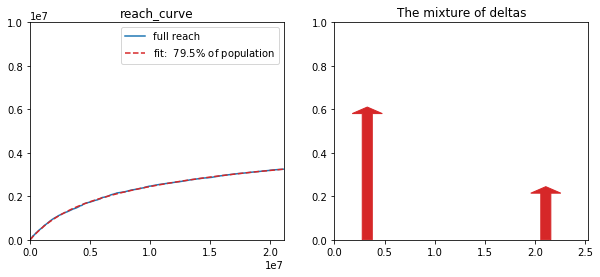

In [4]:
# The observed population is small in size
population_size=5*10**6

# Fitting on the mixture of deltas and plot
alphas, rates = fit_mixture_of_deltas(reach, n_deltas=2, population_size=population_size)
plot_reach_curve(reach, alphas=alphas, rates=rates, 
                 plot_deltas=True, population_size=population_size, 
                 reach_kwargs={'ylim' : (0, 1.0e7)})

In [5]:
df_dirac_mixtures = pd.DataFrame([[1.0, alphas, rates]], columns=['ratio', 'alphas', 'rates'])

# Generate the VID assignment table : probability and VID ranges
vid_assignment_table = spark.createDataFrame(
    generate_vid_assignment_table(df_dirac_mixtures, population_size=population_size, normalize=False)
)

vid_assignment_table.show()

,prob_>=,prob_<,alpha,rate,start_VID,total_VID
0,0.000000,0.189957,0.580465,0.327249,1,2902327
1,0.189957,0.641619,0.214414,2.106500,2902328,1072068
2,0.641619,1.000000,0.000000,0.000000,0,1


In [6]:
# The parameter for plotting the VID counts
vid_reach_kwargs = {
    'jump' : 100,
    'ylim' : (0, 1.0e7),
    'axes_info' : { 
        'color'      : 'C0',
        'linestyle'  : '',
        'marker'     : 'd',
        'markersize' : 4,
        'label'      : 'VID count' }
}

# Use `user_id` as the source of hash function

The basic algorithm suggests to use `cookie_id` or here `user_id`s as the source of randomness. Since the original algorithm deal with a reach curve that is "unique person reach" as a function of "unique cookie reach". However, here we deal with "unique person reach" as a function of "number of impressions/events". The two problem while similear in nature are very different.

If we use `user_id` for the source of hash function that assigns the VIDs, we end up with significant under-estimation of the reach curve. That is because size of pools are determined by the amplitude of the $i$th pool, $\alpha_i$, while the probability of an impression/cookie belonging to each pool is ${\alpha_i x_i}$.

(<matplotlib.figure.Figure at 0x7f6bfa515c88>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6bfa515ba8>,
       dtype=object))

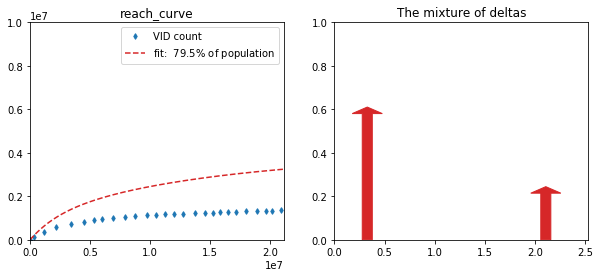

In [7]:
# Using the "uid" mode for the VID assignment that uses `user_id` for the source of randomness
vid_impressions = assign_vids(impressions, vid_assignment_table, population_size=population_size, mode="uid")

vid_reach = generate_reach_table(vid_impressions, id_col="vid", mode="count")

# Plot the VID counts vs reported reach
plot_reach_curve(vid_reach, alphas=alphas, rates=rates, 
                 plot_deltas=True, population_size=population_size, 
                 reach_kwargs=vid_reach_kwargs)

# Use `user_id` and `timestamp` as the source of hash function
As we observed using the user_id as the source of hash function under-estimates the reach curve, to fix that we can remain more true to the original distribution by using a unique id for the source of randomness. We can, for example, try the `user_id` and `timestamp` for the source of hash function to observe the performance of virtual ID assignment to replicate the reach curve.

(<matplotlib.figure.Figure at 0x7f6bfa432588>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6c0809a710>,
       dtype=object))

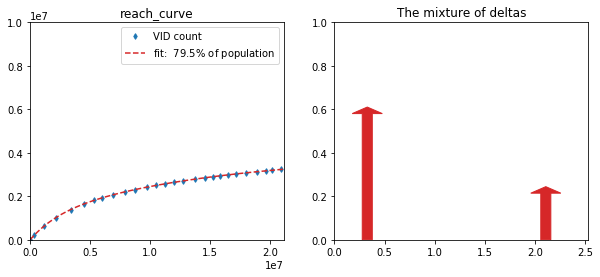

In [8]:
# Using the "uid_time" mode for the VID assignment
vid_impressions = assign_vids(impressions, vid_assignment_table, population_size=population_size, mode="uid_time")

vid_reach = generate_reach_table(vid_impressions, id_col="vid", mode="count")

# Plot the VID counts vs reported reach
plot_reach_curve(vid_reach, alphas=alphas, rates=rates, 
                 plot_deltas=True, population_size=population_size, 
                 reach_kwargs=vid_reach_kwargs)

In [9]:
vid_pool_info = mixture_of_delta_pool_info(vid_impressions, vid_assignment_table)
vid_pool_info.show()

,alpha,rate,alpha * rate,VID_pool_size,impressions,VID_reach,distinct_users
0,0.000000,0.000000,0.000000,1,7574123,1,2347072
1,0.580465,0.327249,0.189957,2902327,4016634,2174670,1766188
2,0.214414,2.106500,0.451662,1072068,9548256,1071931,2559095


# Frequency estimation
Let us now see if frequency estimation also works using the VID. We first calculate the number persons for any given frequency from the report and then compare that to the VID frequency counts.

As is shown by the plot, the frequency distribution of the VID has a exponential decay while the actual TV report data has a long tail (algebraic) fall. How can we address this problem?

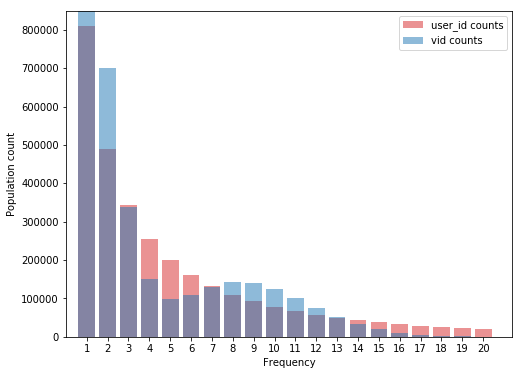

In [10]:
frequency = generate_frequency_table(impressions, id_col="user_id", mode="count")
vid_frequency = generate_frequency_table(vid_impressions, id_col="vid", mode="count")

fig, ax = plt.subplots(figsize=(8, 6))
plot_frequency(frequency, id_col="user_id", axes=ax, color='C3')
plot_frequency(vid_frequency, id_col="vid", axes=ax, color='C0')